<a href="https://colab.research.google.com/github/fadibechara/Boltzmann_GPU/blob/main/Boltzmann_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
###### Flow definition #################################################
maxIter = 200000  # Total number of time iterations.
Re = 150.0         # Reynolds number.
nx, ny = 420, 180 # Numer of lattice nodes.
ly = ny-1         # Height of the domain in lattice units.
cx, cy, r = nx//4, ny//2, ny//9 # Coordinates of the cylinder.
uLB     = 0.04                  # Velocity in lattice units.
nulb    = uLB*r/Re;             # Viscoscity in lattice units.
omega = 1 / (3*nulb+0.5);    # Relaxation parameter.

###### Lattice Constants ###############################################
v = np.array([ [ 1,  1], [ 1,  0], [ 1, -1], [ 0,  1], [ 0,  0],
               [ 0, -1], [-1,  1], [-1,  0], [-1, -1] ])
t = np.array([ 1/36, 1/9, 1/36, 1/9, 4/9, 1/9, 1/36, 1/9, 1/36])

col1 = np.array([0, 1, 2])
col2 = np.array([3, 4, 5])
col3 = np.array([6, 7, 8])

In [29]:
def macroscopic(fin):
    """Compute macroscopic variables (density, velocity)

    fluid density is 0th moment of distribution functions 
    fluid velocity components are 1st order moments of fdist. functions
    """
    rho = np.sum(fin, axis=0)
    u = np.zeros((2, nx, ny))
    for i in range(9):
        u[0,:,:] += v[i,0] * fin[i,:,:]
        u[1,:,:] += v[i,1] * fin[i,:,:]
    u /= rho
    return rho, u
def equilibrium(rho, u):
    """Equilibrium distribution function.
    """
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    feq = np.zeros((9,nx,ny))
    for i in range(9):
        cu = 3 * (v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i] * (1 + cu + 0.5*cu**2 - usqr)
    return feq

In [30]:

def obstacle_fun(x, y):
    return (x-cx)**2+(y-cy)**2<r**2

In [31]:
def inivel(d, x, y):
    return (1-d) * uLB * (1 + 1e-4*np.sin(y/ly*2*np.pi))

In [32]:
def main_cpu(max_iterations):

    # create obstacle mask array from element-wise function
    obstacle = np.fromfunction(obstacle_fun, (nx,ny))

    # initial velocity field vx,vy from element-wise function
    # vel is also used for inflow border condition
    vel = np.fromfunction(inivel, (2,nx,ny))

    # Initialization of the populations at equilibrium 
    # with the given velocity.
    fin = equilibrium(1, vel)

    ###### Main time loop ########
    for time in range(max_iterations):

        # Right wall: outflow condition.
        # we only need here to specify distrib. function for velocities
        # that enter the domain (other that go out, are set by the streaming step)
        fin[col3,nx-1,:] = fin[col3,nx-2,:] 

        # Compute macroscopic variables, density and velocity.
        rho, u = macroscopic(fin)

        # Left wall: inflow condition.
        u[:,0,:] = vel[:,0,:]
        rho[0,:] = 1/(1-u[0,0,:]) * ( np.sum(fin[col2,0,:], axis=0) +
                                      2*np.sum(fin[col3,0,:], axis=0) )
        
        # Compute equilibrium.
        feq = equilibrium(rho, u)
        fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]

        # Collision step.
        fout = fin - omega * (fin - feq)

        # Bounce-back condition for obstacle.
        # in python language, we "slice" fout by obstacle
        for i in range(9):
            fout[i, obstacle] = fin[8-i, obstacle]

        # Streaming step.
        for i in range(9):
            fin[i,:,:] = np.roll(np.roll(fout[i,:,:], v[i,0], axis=0),
                                 v[i,1], axis=1 )
 
        # Visualization of the velocity.
        if (time%100==0):
            #print(time)
            plt.clf()
            plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)
            plt.savefig("vel.{0:04d}.png".format(time//100))

# Sequential Baseline

Examining the Sequential CPU version, we can clearly notice that there is an immense need for parallelisation in this use case as our **sequential** code is taking almost **2 hours** to execute.

This is wehere GPUs come into play as they thrive in an enviroment with high **arithmetic intensity** and **embarassingly parallel** computations.

Since LBM checks both of those boxes, we will proceed to using ***numba*** in an effort to decrease our total execution time thanks to the GPU.

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
Sequential Algorithm Took in SECONDS
5359.781145095825


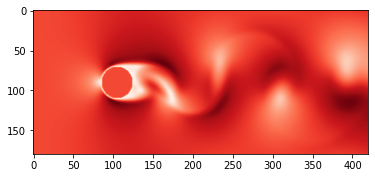

In [ ]:

if __name__ == "__main__":
    %time
    start_time = time.time() # execute only if run as a script
    main_cpu(200000)
    elapsed_time = time.time() - start_time
    print('Sequential Algorithm Took in SECONDS')
    print(elapsed_time)

In [98]:
import plotly.express as px
import numba
from numba import cuda
from matplotlib import cm
import time

###### Moving needed data to device #################################################
n_ = [nx,ny]
n_d = cuda.to_device(nx_)

o_ = [nx,ny,omega]
o_d = cuda.to_device(o_)

v_d = cuda.to_device(v)
t_d = cuda.to_device(t)

col1_d = cuda.to_device(col1)
col2_d = cuda.to_device(col2)
col3_d = cuda.to_device(col3)

blocks_per_grid = 148
threads_per_block = 512

In [103]:
@cuda.jit
def gpu_macroscopic(n_d, rho, fin, v_d, vel, u):
  x = cuda.threadIdx.x
  y = cuda.blockIdx.x
  d = cuda.blockDim.x
  id = y*d + x
  row = int (id/n_d[0])
  col = int (id%n_d[0])
  if (col < n_d[0] and col > 0 and row < n_d[1]):

        tmp_1=0
        tmp_2=0
        for i in range(9):
#writing into local temporary variables so we don't write into global memory each time hence we save 16 writes per thread which is very benificial in the long run with 420*180 threads
            tmp_1 += v_d[i,0] * fin[i,col,row]
            tmp_2 += v_d[i,1] * fin[i,col,row]
        u[0,col,row] = tmp_1/rho[col,row]
        u[1,col,row] = tmp_2/rho[col,row]
  #u[:,0,:] = vel[:,0,:]
  elif (col==0 and row < n_d[1]):
          u[0, col, row] = vel[0,col,row]
          u[1, col, row] = vel[1,col,row]

  cuda.syncthreads()
              
##################################################################################

## fin[col3,nx-1,:] = fin[col3,nx-2,:] 
@cuda.jit
def exchange(n_d, col3, fin):
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    id = y*d + x
    row = int(id/n_d[0])
    col = int(id%n_d[0])
    if (row < n_d[1] and col==n_d[0]-1):
        fin[col3[0],col,row] = fin[col3[0],col-1,row] 
        fin[col3[1],col,row] = fin[col3[1],col-1,row] 
        fin[col3[2],col,row] = fin[col3[2],col-1,row] 
    cuda.syncthreads()

##################################################################        
        
        #rho[0,:] = 1/(1-u[0,0,:]) * ( np.sum(fin[col2,0,:], axis=0) +
                                      #2*np.sum(fin[col3,0,:], axis=0) )
@cuda.jit
def left_wall(n_d, col2, col3, fin, u , rho):
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    id = y*d + x
    row = int(id/n_d[0])
    col = int(id%n_d[0])
    if (row < n_d[1] and col==0):
      tmp_1 = fin[col2[0], 0, row] + fin[col2[1], 0, row] + fin[col2[2], 0, row]
      tmp_2 = fin[col3[0], 0, row] + fin[col3[1], 0, row] + fin[col3[2], 0, row]
      rho[0,row] = 1/(1-u[0,0,row]) * (tmp_1 + 2*tmp_2)
    cuda.syncthreads()

######################################################################     rho = np.sum(fin, axis=0)
@cuda.jit
def rho_cuda(n_d, fin, rho):
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    id = y*d + x
    row = int(id/n_d[0])
    col = int(id%n_d[0])
    if (col < n_d[0] and row < n_d[1]):
        tmp = fin[0,col,row]
        for i in range(1,9,1):
#writing into local temporary variables so we don't write into global memory each time, hence this way we save 8 writes to global memory per thread which is very benificial in the long run with 420*180 threads
              tmp +=  fin[i,col,row]
        rho[col,row] = tmp
    cuda.syncthreads()


#######################################################################
  #fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]
  #In this kernel even tough we are only making use of the Threads which have a col==0, this would be much less computationallty taxing than moving data from gpu to cpu and executing the operation there due to time loss in transfer from DEVICE to HOST and Back from HOST to DEVICE for the remaining operations.
@cuda.jit
def fin_left(n_d, feq, fin):
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    id = y*d + x
    row = int(id/n_d[0])
    col = int(id%n_d[0])
    if (row < n_d[1] and col==0):
      fin[0,0,row] = feq[0,0,row] + fin[8,0,row] - feq[8,0,row]
      fin[1,0,row] = feq[1,0,row] + fin[7,0,row] - feq[7,0,row]
      fin[2,0,row] = feq[2,0,row] + fin[6,0,row] - feq[6,0,row]
    cuda.syncthreads()

############################################################################
        # Bounce-back condition for obstacle.
        # in python language, we "slice" fout by obstacle
        #for i in range(9):
         #   fout[i, obstacle] = fin[8-i, obstacle]

#fout = fin - omega * (fin - feq)
@cuda.jit
def fout_cuda(o_d, obstacle, feq, fin ,fout):
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    id = y*d + x
    row = int(id/o_d[0])
    col = int(id%o_d[0]) ##and ([col,row] not in obstacle)
    s=0
    if (col < o_d[0] and row < o_d[1]):
        if (obstacle[col,row]==True): s = 1

    if (col < o_d[0] and row < o_d[1]):
      for i in range(9):
        fout[i,col,row] = fin[i,col,row] - o_d[2]*(fin[i,col,row] - feq[i,col,row])

            #for i in range(9):
            #fout[i, obstacle] = fin[8-i, obstacle]
            # [col,row] in obstacle

    elif (col < o_d[0] and row < o_d[1] and s==1):
        for i in range(9):
            fout[i, col, row] = fin[8-i, col, row]
    cuda.syncthreads()

##############################################################
# def equilibrium(rho, u):
#     """Equilibrium distribution function.
#     """
#     usqr = 3/2 * (u[0]**2 + u[1]**2)
#     feq = np.zeros((9,nx,ny))
#     for i in range(9):
#         cu = 3 * (v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
#         feq[i,:,:] = rho*t[i] * (1 + cu + 0.5*cu**2 - usqr)
#     return feq


@cuda.jit
def gpu_equilibrium(n_d, rho, u, v, t, feq):
    """Equilibrium distribution function.
    """
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    id = y*d + x
    row = int (id/n_d[0])
    col = int (id%n_d[0])
    if (col < n_d[0] and row < n_d[1]):
        usqr = 3/2 * (u[0,col,row]*u[0,col,row] + u[1,col,row]*u[1,col,row])
        for i in range(9):
          cu = 3 * (v[i,0]*u[0,col,row] + v[i,1]*u[1,col,row])
          feq[i,col,row] = rho[col,row]*t[i] * (1 + cu + 0.5*cu*cu - usqr)
    cuda.syncthreads()

In [109]:
         #   fin[i,:,:] = np.roll(np.roll(fout[i,:,:], v[i,0], axis=0),
          #                       v[i,1], axis=1 )
@cuda.jit 
def stream(n_d, obstacle, fout, fin):
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    id = y*d + x
    row = int (id/n_d[0])
    col = int (id%n_d[0])
    s=0
    if (col < n_d[0] and row < n_d[1]):
        if (obstacle[col,row]==True):s = 1
##Interior Blocks That do not have any boundary issues
    if (col > 0 and col < n_d[0]-1 and row > 0 and row < n_d[1]-1 and s==0):
      fin[0,col,row] = fout[8,col+1,row-1]
      fin[1,col,row] = fout[7,col+1,row]
      fin[2,col,row] = fout[6,col+1,row+1]
      fin[3,col,row] = fout[5,col,row-1]
      fin[5,col,row] = fout[3,col,row+1]
      fin[6,col,row] = fout[2,col-1,row-1]
      fin[7,col,row] = fout[1,col-1,row]
      fin[8,col,row] = fout[0,col-1,row+1]

    #TOP BOUNDARY WITHOUT CORNERS
    elif (row==0 and col > 0 and col < n_d[0]-1):
        fin[1,col,row] = fout[7,col+1,row]
        fin[2,col,row] = fout[6,col+1,row+1]
        fin[5,col,row] = fout[3,col,row+1]
        fin[7,col,row] = fout[1,col-1,row]
        fin[8,col,row] = fout[0,col-1,row+1]
    #BOTTOM BOUNDARY WITHOUT CORNERS
    elif (row==n_d[1]-1 and col > 0 and col < n_d[0]-1):
        fin[0,col,row] = fout[8,col+1,row-1]
        fin[1,col,row] = fout[7,col+1,row]
        fin[3,col,row] = fout[5,col,row-1]
        fin[6,col,row] = fout[2,col-1,row-1]
        fin[7,col,row] = fout[1,col-1,row]
   #LEFT WALL(boundary) WITH CORNERS
    elif (col==0 and row<n_d[1]):
      if (row==0):
        fin[1,col,row] = fout[7,col+1,row]
        fin[2,col,row] = fout[6,col+1,row+1]
        fin[5,col,row] = fout[3,col,row+1]
      elif row==179:
        fin[0,col,row] = fout[8,col+1,row-1]
        fin[1,col,row] = fout[7,col+1,row]
        fin[3,col,row] = fout[5,col,row-1]
      else:##
        fin[0,col,row] = fout[8,col+1,row-1]
        fin[1,col,row] = fout[7,col+1,row]
        fin[2,col,row] = fout[6,col+1,row+1]
        fin[3,col,row] = fout[5,col,row-1]
        fin[5,col,row] = fout[3,col,row+1]
    #RIGHT WALL(boundary) WITH CORNERS
    elif (col==n_d[0]-1 and row<n_d[1]):
      if row==0:
        fin[5,col,row] = fout[3,col,row+1]
        fin[7,col,row] = fout[1,col-1,row]
        fin[8,col,row] = fout[0,col-1,row+1]
      elif row==179:##
        fin[3,col,row] = fout[5,col,row-1]
        fin[6,col,row] = fout[2,col-1,row-1]
        fin[7,col,row] = fout[1,col-1,row]
      else :
        fin[3,col,row] = fout[5,col,row-1]
        fin[5,col,row] = fout[3,col,row+1]
        fin[6,col,row] = fout[2,col-1,row-1]
        fin[7,col,row] = fout[1,col-1,row]
        fin[8,col,row] = fout[0,col-1,row+1]
      
    cuda.syncthreads()



In [105]:
def main_gpu(max_iterations):

    # create obstacle mask array from element-wise function
    obstacle = np.fromfunction(obstacle_fun, (nx,ny))
    obstacle_gpu = cuda.to_device(obstacle)


    # initial velocity field vx,vy from element-wise function
    # vel is also used for inflow border condition
    vel = np.fromfunction(inivel, (2,nx,ny))
    vel_gpu = cuda.to_device(vel)

    fin = np.zeros((9,nx,ny))
    fin_gpu = cuda.to_device(fin)

    feq = np.zeros((9,nx,ny))
    feq_gpu = cuda.to_device(feq)

    fout = np.zeros((9,nx,ny))
    fout_gpu = cuda.to_device(fout)

    rho_init = np.ones((nx,ny))
    rho_init_gpu = cuda.to_device(rho_init)
    gpu_equilibrium[blocks_per_grid, threads_per_block](n_d, rho_init_gpu, vel_gpu, v_d, t_d, fin_gpu)

    rho = np.zeros((nx,ny), float)
    rho_gpu = cuda.to_device(rho)
    u = np.zeros((2, nx, ny))
    u_gpu = cuda.to_device(u)


    ###### Main time loop ########
    for time in range(max_iterations):

        # Right wall: outflow condition.
        # we only need here to specify distrib. function for velocities
        # that enter the domain (other that go out, are set by the streaming step)

        exchange[blocks_per_grid, threads_per_block](n_d, col3_d, fin_gpu)
        

        # Compute macroscopic variables, density and velocity.


        rho_cuda[blocks_per_grid, threads_per_block](n_d, fin_gpu, rho_gpu)

        gpu_macroscopic[blocks_per_grid, threads_per_block](n_d, rho_gpu, fin_gpu, v_d, vel_gpu, u_gpu)         #u[:,0,:] = vel[:,0,:] step included in macroscopic kernel

        # Left wall: inflow condition.

        left_wall[blocks_per_grid, threads_per_block](n_d, col2_d, col3_d ,fin_gpu, u_gpu, rho_gpu)    
        # Compute equilibrium.


        gpu_equilibrium[blocks_per_grid, threads_per_block](n_d, rho_gpu, u_gpu, v_d, t_d, feq_gpu)

        fin_left[blocks_per_grid, threads_per_block](n_d, feq_gpu, fin_gpu)
 
        # Collision step.

        fout_cuda[blocks_per_grid, threads_per_block](o_d, obstacle_gpu, feq_gpu, fin_gpu, fout_gpu) #   fout[i, obstacle] = fin[8-i, obstacle] step included in fout_cuda kernel

        # STREAMING STEP
        stream[blocks_per_grid, threads_per_block](n_d, obstacle_gpu, fout_gpu, fin_gpu)



        # Visualization of the velocity.
        if (time%100==0):
            #print('100 -------------------------------------------------------')
            u = u_gpu.copy_to_host()
            plt.clf()
            plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)
            plt.savefig("vel.{0:04d}.png".format(time//100))



******************************************

Number of Iterations: 1.000
Algorithm on GPU Took 0.121 SECONDS
Algorithm on CPU Took 0.135 SECONDS
SPEEDUP achieved due to GPU: 111.355 %

******************************************

Number of Iterations: 10.000
Algorithm on GPU Took 0.141 SECONDS
Algorithm on CPU Took 0.354 SECONDS
SPEEDUP achieved due to GPU: 251.699 %

******************************************

Number of Iterations: 100.000
Algorithm on GPU Took 0.304 SECONDS
Algorithm on CPU Took 2.186 SECONDS
SPEEDUP achieved due to GPU: 718.728 %

******************************************

Number of Iterations: 500.000
Algorithm on GPU Took 1.471 SECONDS
Algorithm on CPU Took 10.263 SECONDS
SPEEDUP achieved due to GPU: 697.598 %

******************************************

Number of Iterations: 1000.000
Algorithm on GPU Took 2.896 SECONDS
Algorithm on CPU Took 21.197 SECONDS
SPEEDUP achieved due to GPU: 731.961 %

******************************************

Number of Iterations: 250

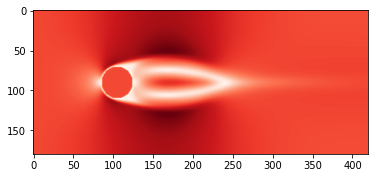

In [66]:
if __name__ == "__main__":
    iter = [1, 10, 100, 500, 1000, 2500, 5000, 10000]
    gpu_time = []
    cpu_time = []
    speedup_list = []
    main_gpu(10000)
    for i in iter:
        print('\n******************************************\n')
        print('Number of Iterations: {0:.3f}'.format(i))
        start_time = time.time() # execute only if run as a script
        main_gpu(i)
        elapsed_time_gpu = time.time() - start_time
        gpu_time.append(elapsed_time_gpu)
        print('Algorithm on GPU Took {0:.3f} SECONDS'.format(elapsed_time_gpu))
        start_time = time.time()
        main_cpu(i)
        elapsed_time_cpu = time.time() - start_time
        cpu_time.append(elapsed_time_cpu)
        speedup = elapsed_time_cpu/elapsed_time_gpu
        speedup_list.append(speedup)
        print('Algorithm on CPU Took {0:.3f} SECONDS'.format(elapsed_time_cpu))
        print("SPEEDUP achieved due to GPU: {0:.3f} %".format(speedup*100))
    Time_DIFF = pd.DataFrame({'GPU_TIME': gpu_time,'CPU_TIME': cpu_time, 'Number_of_Iterations': iter})
    print(Time_DIFF)
    benchmark = pd.DataFrame({'Speedup': speedup_list,'Number_of_Iterations': iter})
    fig = px.line(benchmark, x = 'Number_of_Iterations', y = 'Speedup', title = 'Boltzmann Benchmark GPU')
    fig.show()
